In [0]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [0]:
# 將 google drive 掛載在 colob
from google.colab import drive 
drive.mount('/content/gdrive')
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive/AI/Final_Project'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/AI/Final_Project
/content/gdrive/My Drive/AI/Final_Project/keras-yolo3


In [0]:
!pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
import os

In [0]:
# 下載資料集
#!git clone https://github.com/experiencor/raccoon_dataset.git
#!git clone https://github.com/experiencor/kangaroo.git

# 下載測試影片
'''
!pip install pytube3 --upgrade

def download_video(url, path, filename):
    import os
    from pytube import YouTube
    yt = YouTube(url)
    title = yt.title
    print('開始下載... {} 到 {}'.format(title, path))
    yt.streams.first().download(path)
    print('下載結束')
    print('更改檔名... {}'.format(filename))
    title = title+'.mp4'
    filename = filename+'.mp4'
    old = os.path.join(path, title)
    new = os.path.join(path, filename)
    os.system('mv {} {}'.format(old, new))
    if os.path.exists(new):
        print('更改成功')
    else:
        print('更改失敗')

to_path = './video'
kangaroo_url = 'https://www.youtube.com/watch?v=bv3kx7uHRzI&feature=emb_logo'
raccoon_url = 'https://www.youtube.com/watch?v=J6hA2tT7qvg'
download_video(kangaroo_url, to_path, 'kangaroo')
download_video(raccoon_url, to_path, 'raccoon')
'''
# 自備測試資料集 ./test
# 網路圖片, 袋鼠和浣熊類共19張, 並用 labelImg 標註備用
# 從範例下載測試影片 ./video

"\n!pip install pytube3 --upgrade\n\ndef download_video(url, path, filename):\n    import os\n    from pytube import YouTube\n    yt = YouTube(url)\n    title = yt.title\n    print('開始下載... {} 到 {}'.format(title, path))\n    yt.streams.first().download(path)\n    print('下載結束')\n    print('更改檔名... {}'.format(filename))\n    title = title+'.mp4'\n    filename = filename+'.mp4'\n    old = os.path.join(path, title)\n    new = os.path.join(path, filename)\n    os.system('mv {} {}'.format(old, new))\n    if os.path.exists(new):\n        print('更改成功')\n    else:\n        print('更改失敗')\n\nto_path = './video'\nkangaroo_url = 'https://www.youtube.com/watch?v=bv3kx7uHRzI&feature=emb_logo'\nraccoon_url = 'https://www.youtube.com/watch?v=J6hA2tT7qvg'\ndownload_video(kangaroo_url, to_path, 'kangaroo')\ndownload_video(raccoon_url, to_path, 'raccoon')\n"

In [0]:
!ls

coco_annotation.py		 test
convert.py			 test_annot.txt
darknet53.cfg			 train_annot.txt
Day41_train_yolov3_Sample.ipynb  train_bottleneck.py
dog.jpg				 train.py
font				 video
horses.jpg			 voc_annotation.py
kangaroo			 VOCdevkit
kmeans.py			 VOCtrainval_06-Nov-2007.tar
LICENSE				 yolo3
logs				 yolo.py
model_data			 yolov3.cfg
__pycache__			 yolov3-tiny.cfg
raccoon_dataset			 yolov3-tiny.weights
README.md			 yolov3.weights
results				 yolo_video.py


In [0]:
# 解析標註檔 xml 轉換成標註檔
# 先定義目標類別
classes = ['kangaroo', 'raccoon']

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(xml, to_file, classes):
    import xml.etree.ElementTree as ET
    with open(xml, 'r') as f:
      tree = ET.parse(f)
      root = tree.getroot()

      for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
          continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        to_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

def convert(images_dir, annot_dir, to_file, classes):
    import os
    with open(to_file, 'w') as to_file:
      for i, annot_path in enumerate(annot_dir):
        annots = os.listdir(annot_path)
        for annot in annots:
          filename = annot.split('.')[0]
          to_file.write(os.path.join(images_dir[i], f'{filename}.jpg'))
          convert_annotation(os.path.join(annot_path, annot), to_file, classes)
          to_file.write('\n')

# 訓練驗證用標註檔
if not os.path.exists('train_annot.txt'):
  print("train_annot.txt doesn't exists, converting ... ")
  # 資料夾位置
  images_dir = ['kangaroo/images', 'raccoon_dataset/images']
  annot_dir = ['kangaroo/annots', 'raccoon_dataset/annotations']

  convert(images_dir, annot_dir, 'train_annot.txt', classes)
  print('train_annot.txt is ready ...')
else:
  print('train_annot.txt exists')

train_annot.txt exists


In [0]:
# 類別檔案
def class_txt(to_file, classes):
  with open(to_file, 'w') as f:
    for cls in classes:
      f.write(cls)
      f.write('\n')

if not os.path.exists('model_data/animal_classes.txt'):
    print('Generating model_data/animal_classes.txt ...')
    class_txt('model_data/animal_classes.txt', classes)
    print('model_data/animal_classes.txt is ready ...')
else:
    print('model_data/animal_classes.txt exists ...')


model_data/animal_classes.txt exists ...


In [0]:
# 預訓練權重檔案
if not os.path.exists("model_data/yolo_weights.h5"):
  print("model_data/yolo_weights.h5 does not exist, converting pretrained YOLOv3 weights for training .. ")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
  if not os.path.exists("model_data/yolo_weights.h5"):
    print('Convert Fail ...')
  else:
    print('model_data/yolo_weights.h5 is ready ...')
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
# 將所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from yolo import YOLO
from PIL import Image
import cv2
from IPython import display
from yolo3.model import box_iou

Using TensorFlow backend.


In [0]:
# 相關資料夾和路徑、參數設定

#!mkdir logs/003
#!mkdir results/003
#!mkdir results/video

annotation_path = 'train_annot.txt' # 轉換好格式的訓練驗證集標註檔案
test_dir = 'test/images'            # 測試資料集圖片
test_annotation = 'test_annot.txt'  # 測試資料集標註檔

log_dir = 'logs/003/'               # 訓練好的模型儲存的路徑
result_dir = 'results/003'          # 辨識測試資料結果
test_video_dir = 'video/'           # 測試影片
out_video_dir = 'results/video/'    # 辨識測試影片結果
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw
iou_threshold = 0.6                # 辨識測試資料用的 iou 門檻值

In [0]:
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val















Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 8
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                  steps_per_epoch=max(1, num_train//batch_size),
                                  validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                  validation_steps=max(1, num_val//batch_size),
                                  epochs=50,
                                  initial_epoch=0,
                                  callbacks=[])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Train on 328 samples, val on 36 samples, with batch size 8.


Epoch 1/50
41/41 [==============================] - 151s 4s/step - loss: 995.1605 - val_loss: 124.0190
Epoch 2/50
41/41 [==============================] - 22s 547ms/step - loss: 100.6242 - val_loss: 76.6847
Epoch 3/50
41/41 [==============================] - 24s 577ms/step - loss: 67.5599 - val_loss: 55.0184
Epoch 4/50
41/41 [==============================] - 24s 579ms/step - loss: 53.1647 - val_loss: 44.8469
Epoch 5/50
41/41 [==============================] - 24s 589ms/step - loss: 45.0803 - val_loss: 39.3087
Epoch 6/50
41/41 [==============================] - 24s 584ms/step - loss: 38.3648 - val_loss: 33.0207
Epoch 7/50
41/41 [==============================] - 24s 583ms/step - loss: 35.0462 - val_loss: 30.6849
Epoch 8/50
41/41 [==============================] - 24s 579ms/step - loss: 32.4076 - val_loss: 28.2585
Epoch 9/50
41/41 [==============================] - 24s 575ms/step - loss: 29.8898 - val_loss: 28.6154
Epoch 10/

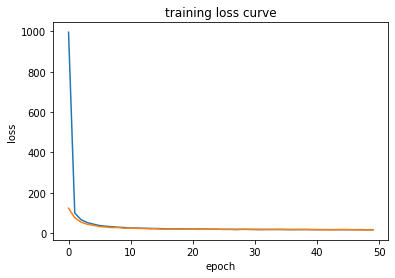

In [0]:
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss curve')
plt.savefig('logs/003/training_loss_phase1.png')
plt.show()

In [0]:
# Unfreeze half and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把一半 layer 都改為 trainable
    for i in range(len(model.layers)//2, len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze half of the layers.')

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                  steps_per_epoch=max(1, num_train//batch_size),
                                  validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                  validation_steps=max(1, num_val//batch_size),
                                  epochs=100,
                                  initial_epoch=50,
                                  callbacks=[logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_stage2.h5')

Unfreeze half of the layers.
Train on 328 samples, val on 36 samples, with batch size 8.


Epoch 51/100
41/41 [==============================] - 33s 803ms/step - loss: 17.8026 - val_loss: 16.2248

Epoch 52/100
41/41 [==============================] - 23s 560ms/step - loss: 16.0950 - val_loss: 15.4733
Epoch 53/100
41/41 [==============================] - 25s 601ms/step - loss: 15.5805 - val_loss: 16.9602
Epoch 54/100
41/41 [==============================] - 25s 609ms/step - loss: 15.4226 - val_loss: 14.6872
Epoch 55/100
41/41 [==============================] - 25s 605ms/step - loss: 14.9347 - val_loss: 15.9992
Epoch 56/100
41/41 [==============================] - 25s 604ms/step - loss: 14.5932 - val_loss: 15.5029
Epoch 57/100
41/41 [==============================] - 25s 606ms/step - loss: 14.5642 - val_loss: 15.8795

Epoch 00057: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 58/100
41/41 [==============================] - 24s 574ms/step - loss: 14.3343 - val_l

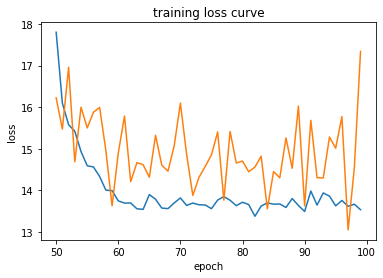

In [0]:
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss curve')
plt.savefig('logs/003/training_loss_phase2.png')
plt.show()

In [0]:
# Unfreeze all and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)//2):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                  steps_per_epoch=max(1, num_train//batch_size),
                                  validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                  validation_steps=max(1, num_val//batch_size),
                                  epochs=150,
                                  initial_epoch=100,
                                  callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Unfreeze all of the layers.
Train on 328 samples, val on 36 samples, with batch size 4.
Epoch 101/150
82/82 [==============================] - 38s 468ms/step - loss: 15.5440 - val_loss: 17.1628
Epoch 102/150
82/82 [==============================] - 26s 321ms/step - loss: 15.3896 - val_loss: 16.2835
Epoch 103/150
82/82 [==============================] - 29s 352ms/step - loss: 15.1761 - val_loss: 15.9212
Epoch 104/150
82/82 [==============================] - 29s 348ms/step - loss: 15.1141 - val_loss: 15.6889
Epoch 105/150
82/82 [==============================] - 29s 353ms/step - loss: 14.9900 - val_loss: 16.2194
Epoch 106/150
82/82 [==============================] - 29s 351ms/step - loss: 14.5292 - val_loss: 16.9290
Epoch 107/150
82/82 [==============================] - 29s 350ms/step - loss: 14.7526 - val_loss: 15.9961

Epoch 00107: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 108/150
82/82 [==============================] - 26s 323ms/step - loss: 14.1160 - v

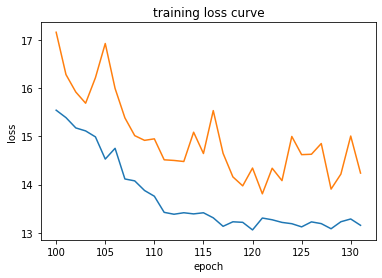

In [0]:
plt.plot(history.epoch, history.history['loss'], history.epoch, history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss curve')
plt.savefig('logs/003/training_loss_final.png')
plt.show()

In [0]:
# 測試資料集的標註檔

if not os.path.exists('test_annot.txt'):
  print("test_annot.txt doesn't exists, converting ... ")
  # 資料夾位置
  test_images_dir = ['test/images']
  test_annot_dir = ['test/annotations']

  convert(test_images_dir, test_annot_dir, 'test_annot.txt', classes)
  if not os.path.exists('test_annot.txt'):
     print('Convert Fail ... ')
  else:
     print('test_annot.txt is ready ...')
else:
  print('test_annot.txt exists')

test_annot.txt exists


In [0]:
# 自定義函數: 畫 groundtruth box, iou 計算, 模型預測輸出, 畫 precision-recall curve 

def draw_box(image, box, classes):            # 用來畫測試圖片中的 groundtruth box
    from PIL import ImageFont, ImageDraw
    [x1, y1, x2, y2, cls] = box
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(classes[cls], font)
    for i in range(3):
        draw.rectangle([x1+i, y1+i, x2-i, y2-i], outline='yellow')
    draw.rectangle([x1, y1-label_size[1], x1+label_size[0], y1], fill='yellow', outline='yellow')
    draw.text((x1, y1-label_size[1]), classes[cls], fill=(0, 0, 0), font=font)
    del draw
    return image

def transfer_box(box):                        # 轉換成 yolo.util 中的 box_iou 所需的 bbox 輸入為 xyhw
    '''
    (x1, y1, x2, y2) -> (x, y, w, h)
    '''
    [x1, y1, x2, y2] = box
    
    return [(x1+x2)/2., (y1+y2)/2., x2-x1, y2-y1]

def model_predict(yolo_model, test_dir, test_annotation, result_dir, iou_threshold=0.5):    # 模型預測, 畫圖和回傳計算 precision-recall curve 所需資料
      with open(test_annotation, 'r') as f:
          iou_ind = 0
          count = 0
          y_true = []                                                    # 對每個預測框和 groundtruth 比對時, 對結果做分類
          y_pred = []
          num_allgroundbox = 0
          
          for line, file in zip(f.readlines(), sorted(os.listdir(test_dir))):    # 處理每張測試圖片, 並讀取 groundtruth 資訊和每個預測框做比較和獲取相關指標參數
              image = Image.open(os.path.join(test_dir, file))           # 讀取範例圖片
              
              r_img, out_boxes, out_scores, out_classes = yolo_model.detect_image_revise(image)    # 改寫 detect_image, 獲得預測框圖片和資訊
              
              items = line.split()[1:]
              num_boxes = 0                                              # 計算預測框和 groundtruth box 總量
              total_iou = 0                                              # iou 總分
              ground_boxes = []
              ground_label = []
              
              for item in items:                                      # 先畫出所有 groundtruth 到圖片中
                  box = [int(z) for z in item.split(',')]
                  r_img = draw_box(r_img, box, classes)
                  box_tran = transfer_box(box[:4])
                  ground_boxes.append(box_tran)
                  ground_label.append(box[-1])
              
              num_allgroundbox += len(ground_boxes)                   # groundtruth 數量

              if len(out_boxes) > 0 :                                 # 如果預測框存在(因為有測試圖片完全沒預測中)
                  out_boxes_tran = []
                  for b in out_boxes:                                 # 把預測框資訊轉換成 xyhw
                      [y1, x1, y2, x2] = b
                      b_temp = [x1, y1, x2, y2]
                      out_boxes_tran.append(transfer_box(b_temp))
                      
                  cf_order = np.argsort(out_scores)[::-1]             # 所有預測框的信心分數排序由大到小
                  cf_order = list(cf_order)

                  for i in cf_order:                                  # 每個預測框對所有 groundtruth 算 iou
                      if len(ground_boxes) > 0:
                          num_boxes +=1
                          iou = box_iou(K.variable(ground_boxes), K.variable(out_boxes_tran[i]))
                          best_iou = K.get_value(K.max(iou))
                          best_idx = K.get_value(K.argmax(iou, axis=0))[0]
                          #print(best_iou)
                          #print(best_idx)
                          if best_iou > iou_threshold:                       # 假如得到最高的 iou > threshold 且 預測類別正確 
                              if out_classes[i] == ground_label[best_idx]:   # 則歸類為 TP 並移除該 groundtruth 
                                  total_iou += best_iou
                                  y_true.append(1)
                                  y_pred.append(1)
                                  ground_boxes.pop(best_idx)
                                  ground_label.pop(best_idx)
                              else:                                          # 若預測類別錯誤則歸類為 FP
                                  y_true.append(0)
                                  y_pred.append(1)
                          else:
                              y_true.append(0)                               # 若 iou < threshold 則歸類為 FP
                              y_pred.append(1)
                          #print(K.get_value(iou))
                      else:                                                  # 若有剩餘預測框表示預測錯誤, 歸類為 FP
                          rest = len(cf_order)-cf_order.index(i)   
                          num_boxes += rest
                          for k in range(rest):
                              y_true.append(0)
                              y_pred.append(1)
                          break
                  
                  if len(ground_boxes) > 0:                                  # 若有剩餘 groundtruth 表示沒被預測到, 歸類為 FN
                      num_boxes += len(ground_boxes)
                      for j in range(len(ground_boxes)):
                          y_true.append(1)
                          y_pred.append(0)                
              
              else:                                                          # 完全沒有預測到東西, 歸類為 FN
                  num_boxes += len(ground_boxes)
                  for j in range(len(ground_boxes)):
                      y_true.append(1)
                      y_pred.append(0)    
              
              iou_av = total_iou/num_boxes
              print('iou average in this figure = ', iou_av)
              iou_ind += iou_av
              count += 1
              r_img.save(os.path.join(result_dir, file))
              display.display(r_img)
          IOU = iou_ind/count
          print('iou indicator of this model for the testing sets = ', IOU)         # 模型 IOU 指標
          #print('total test items = ', count)

      #print(y_true)
      #print(y_pred)
      return y_true, y_pred, IOU, num_allgroundbox

def precision_recall_curve(y_true, y_pred, num_allgroundbox, result_dir):                      # precision-recall curve 並回傳 mAP
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    precision = []
    recall = []

    tp = 0
    fp = 0

    for t, p in zip(y_true, y_pred):
        if (t, p) == (1, 1):
            tp += 1
        elif (t, p) == (0, 1):
            fp += 1
        else:
            pass
        precision.append(tp/(tp+fp))
        recall.append(tp/num_allgroundbox)

    #print(precision)
    #print(recall)
    plt.step(recall, precision, color='r', alpha=1, where='post')
    #plt.fill_between(recall, precision, alpha=0.2, color='g', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.savefig(os.path.join(result_dir, 'precision_recall_curve.png'))
    plt.show()

    return np.mean(precision)

In [0]:
# 載入 yolo 模型和訓練後權重
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

y_true, y_pred, IOU, num_allgroundbox = model_predict(yolo_model, test_dir, test_annotation, result_dir, iou_threshold)

mAP = precision_recall_curve(y_true, y_pred, num_allgroundbox, result_dir)
print('mAP = ', mAP)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
from yolo import YOLO

def detect_video_revise(yolo_model, video_path, output_path):
    import cv2
    import numpy as np
    from PIL import Image
    import time

    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    
    #video_fourcc = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps = vid.get(cv2.CAP_PROP_FPS)
    video_size = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    # 建立 VideoWriter 物件，寫入影片
    out = cv2.VideoWriter(output_path, video_fourcc, video_fps, video_size)
    if not out.isOpened():
        raise IOError("Couldn't open video writer")

    start= time.time()
    k = 0
    while True:
        value, frame = vid.read()
        if value:
            # 寫入影格
            image = Image.fromarray(frame)
            image = yolo_model.detect_image(image)
            result = np.array(image)
            out.write(result)
            k += 1
        else:
            break
    
    end = time.time()
    # 釋放所有資源
    vid.release()
    out.release()
    print('共耗時:',round((end-start), 2), '秒，FPS:', round(k/(end-start), 2))

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)    
test_video_dir = 'video/'
out_video_dir = 'results/video/'

for video in os.listdir(test_video_dir):
    video_path = os.path.join(test_video_dir, video)
    output_path = os.path.join(out_video_dir, 'result_'+video)
    detect_video_revise(yolo_model, video_path=video_path, output_path=output_path)

Streaming output truncated to the last 5000 lines.
1.589355625999815
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (71, 0) (1234, 705)
1.5932603950004705
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (78, 0) (1230, 708)
1.6004585619994032
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (76, 0) (1234, 714)
1.5870626510004513
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (80, 0) (1228, 712)
1.5787297589995433
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (75, 0) (1233, 715)
1.5812943820001237
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (72, 0) (1235, 718)
1.5768520349993196
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (75, 0) (1229, 720)
1.5829562709996026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (74, 0) (1230, 720)
1.5815228310002567
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (73, 0) (1229, 720)
1.5779464930001268
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (72, 0) (1232, 720)
1.5849600499996086
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (6